In [1]:
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

## Preparation

### tokenizer

In [4]:
model_dir = Path("~/ai-data/llama3/Meta-Llama-3-8B").expanduser()
tokenizer_path = model_dir.joinpath("tokenizer.model")
special_tokens = [
    "<|begin_of_text|>",
    "<|end_of_text|>",
    "<|reserved_special_token_0|>",
    "<|reserved_special_token_1|>",
    "<|reserved_special_token_2|>",
    "<|reserved_special_token_3|>",
    "<|start_header_id|>",
    "<|end_header_id|>",
    "<|reserved_special_token_4|>",
    "<|eot_id|>",
] + [f"<|reserved_special_token{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(str(tokenizer_path))
tokenizer = tiktoken.Encoding(
    name=tokenizer_path.name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)
assert tokenizer.decode(tokenizer.encode("Hello, world!")) == "Hello, world!"

### load model weights

In [5]:
model = torch.load(model_dir.joinpath("consolidated.00.pth"))
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [6]:
with open(model_dir.joinpath("params.json"), "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [7]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

### text to tokens

In [11]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


### tokens to embeddings

In [12]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

### normalize embeddings

In [13]:
def rms_norm(tensor: torch.Tensor, norm_weights: torch.Tensor) -> torch.Tensor:
    """Normalize the last dimension of tensor by dividing by the RMS norm."""
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

## building the 1st layer

In [14]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
print(token_embeddings.shape)

torch.Size([17, 4096])


The model weights combine all attentions heads


In [16]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


We unwrap each attention head:

In [17]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
print(q_layer0.shape)

torch.Size([32, 128, 4096])


implementation of the 1st head of the 1st layer

In [18]:
q_layer0_head0 = q_layer0[0]
print("shape of the 1st attention head query matrix:", q_layer0_head0.shape)

shape of the 1st attention head q: torch.Size([128, 4096])


compute the query vectors for the input tokens

In [19]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
print("shape of the 1st attention head query vector:", q_per_token.shape)


shape of the 1st attention head query vector: torch.Size([17, 128])


### RoPE 

In [21]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
print(q_per_token_split_into_pairs.shape)

torch.Size([17, 64, 2])


In [22]:
zero_to_one_split_into_64_parts = torch.tensor(range(64)) / 64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [23]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [26]:
freqs_for_each_token = torch.outer(torch.arange(tokens.shape[0]), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
print(f"freqs_for_each_token shape: {freqs_for_each_token.shape}")

freqs_for_each_token shape: torch.Size([17, 64])


Text(0, 0.5, 'imag')

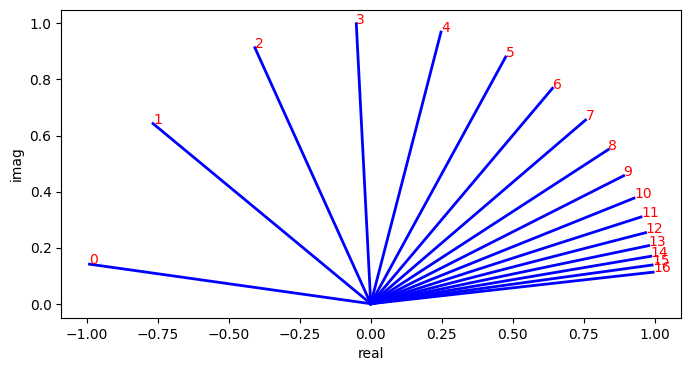

In [29]:
# viewing the 3rd row of freqs_cis
value = freqs_cis[3]
plt.figure(figsize=(8, 4))
for i, element in enumerate(value[:tokens.shape[0]]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=2, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel("real")
plt.ylabel("imag")

### process the queries `q`

In [30]:
q_per_token_as_complex = torch.view_as_complex(q_per_token_split_into_pairs)
print(q_per_token_as_complex.shape)

torch.Size([17, 64])


In [31]:
q_per_token_as_complex_rotated = q_per_token_as_complex * freqs_cis
print(q_per_token_as_complex_rotated.shape)

torch.Size([17, 64])


In [32]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_rotated)
print(q_per_token_split_into_pairs_rotated.shape)

torch.Size([17, 64, 2])


In [33]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
print(q_per_token_rotated.shape)

torch.Size([17, 128])


### process the keys

In [34]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
print(k_layer0.shape)

torch.Size([8, 128, 4096])


In [35]:
k_layer0_head0 = k_layer0[0]
print("shape of the 1st attention head key matrix:", k_layer0_head0.shape)

shape of the 1st attention head key matrix: torch.Size([128, 4096])


In [36]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
print("shape of the 1st attention head key vector:", k_per_token.shape)

shape of the 1st attention head key vector: torch.Size([17, 128])


In [37]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
print(k_per_token_split_into_pairs.shape)

torch.Size([17, 64, 2])


In [38]:
k_per_token_as_complex = torch.view_as_complex(k_per_token_split_into_pairs)
print(k_per_token_as_complex.shape)

torch.Size([17, 64])


In [39]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex * freqs_cis)
print(k_per_token_split_into_pairs_rotated.shape)

torch.Size([17, 64, 2])


In [40]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
print(k_per_token_rotated.shape)

torch.Size([17, 128])


### compute product key * query

In [41]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T) / (head_dim ** 0.5)
print(qk_per_token.shape)

torch.Size([17, 17])


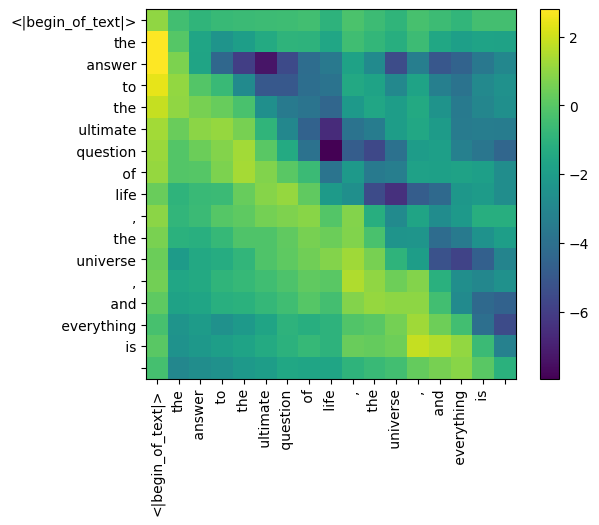

In [47]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens, rotation=90)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

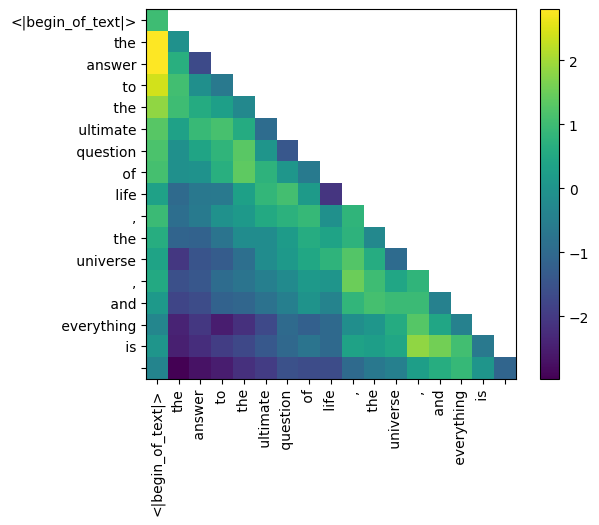

In [48]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)

qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

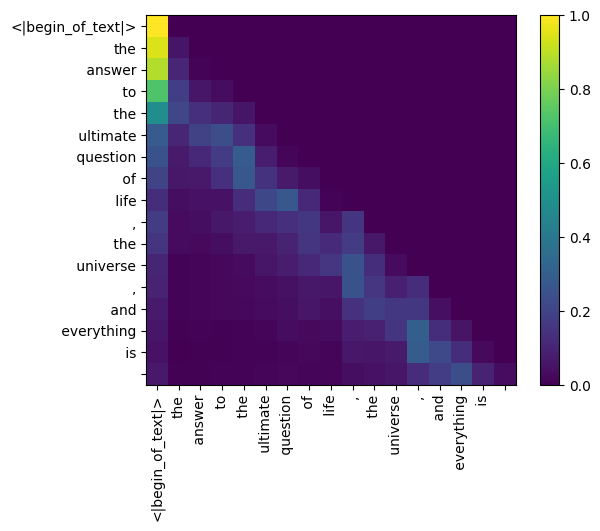

In [49]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

### values

In [50]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
print(v_layer0.shape)

torch.Size([8, 128, 4096])


In [51]:
v_layer0_head0 = v_layer0[0]
print("shape of the 1st attention head value matrix:", v_layer0_head0.shape)

shape of the 1st attention head value matrix: torch.Size([128, 4096])


In [53]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
print(v_per_token.shape)

torch.Size([17, 128])


### attention

In [54]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
print(qkv_attention.shape)

torch.Size([17, 128])


### iterate over heads

In [55]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

In [56]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

### weight matrix

In [57]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

In [58]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

In [59]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta

### normalize & feed forward

In [61]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
print(embedding_after_edit.shape)

torch.Size([17, 4096])


In [62]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

## all layers

In [63]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

### predict next token

In [64]:
final_embedding = rms_norm(final_embedding, model[f"norm.weight"])
print(final_embedding.shape)

torch.Size([17, 4096])


In [65]:
model["output.weight"].shape

torch.Size([128256, 4096])

In [67]:
logits = torch.matmul(final_embedding[-1], model[f"output.weight"].T)
print(logits.shape)

torch.Size([128256])


In [68]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

In [69]:
tokenizer.decode([next_token.item()])

'42'